In [9]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [10]:
%%appyter code_exec

{% do SectionField(
    name='Datasets',
    title='Datasets',
    subtitle='RNA predictions'
)%}

gene = {{ AutocompleteField(
    name='autocomplete',
    label='autocomplete',
    description='autocomplete',
    section='Datasets',
    default='TSPAN6'
)}}

```python

gene = 'TSPAN6'
```

In [11]:
import h5py
import pandas as pd
import numpy as np
import tqdm as trange
from scipy.stats import zscore
import urllib.request
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot
from IPython.display import display_html, HTML
import requests
import os
import pyarrow.feather as feather 

In [13]:
url = 'https://appyters.maayanlab.cloud/storage/ncRNA_predictions/tcga.h5'
if not os.path.exists("tcga.h5"):
    with open("tcga.h5", 'wb') as fout:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        for block in response.iter_content(200*1024**2):
            fout.write(block)

In [14]:
url = 'https://s3.amazonaws.com/mssm-data/human_correlation_archs4.f'
if not os.path.exists("human_correlation_archs4"):
    with open("human_correlation_archs4", 'wb') as fout:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        for block in response.iter_content(200*1024**2):
            fout.write(block)

In [15]:
f = h5py.File("tcga.h5", "r")
tcga_cor = f['corr_matrix']
tcga_genes = [str(g[0])[2:-1] for g in f['tcga_genes']]
filtered_genes = [str(g[0])[2:-1] for g in f['filtered_genes']]

In [16]:
archs4_cor = feather.read_feather("human_correlation_archs4")
archs4_genes = list(archs4_cor.columns) 

In [17]:
libraries = ['KEGG_2019_Human', 'GO_Biological_Process_2018', 'MGI_Mammalian_Phenotype_Level_4_2019', 
             'ChEA_2016', 'KEA_2015']

In [18]:
def display_side_by_side(df1, df2):
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('TCGA')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('ARCHS4')
    display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

In [19]:
def process(current_lib, tcga_genes, filtered_genes, tcga_cor, archs4_genes, archs4_cor):
    pheno_to_genes, gene_set = gene_set_dictionaries(current_lib)
    binary_matrix = gs_binary_matrix(pheno_to_genes, gene_set)
    cor = correlation_matrix(binary_matrix)
    gslib = gene_set_library(cor, pheno_to_genes)
    tcga_pred_matrix = prediction_matrix(gene, tcga_cor, filtered_genes, gslib, tcga_genes)
    archs4_pred_matrix = prediction_matrix(gene, archs4_cor, archs4_genes, gslib)
    top_tcga_phenotypes = get_top_phenotypes(tcga_pred_matrix, gene)
    top_archs4_phenotypes = get_top_phenotypes(archs4_pred_matrix, gene)
    if gene in gene_set: auc(binary_matrix.loc[gene], tcga_pred_matrix, archs4_pred_matrix, gene)
    else: print("Not enough gene annotations available.")
    display_side_by_side(top_tcga_phenotypes, top_archs4_phenotypes)


def gene_set_dictionaries(library):
    """
    Given a gene set library, extract a gene set dictionary from Enrichr
    with (phenotypes, genes) and a sorted set of genes
    """
    enrichr_url = 'https://amp.pharm.mssm.edu/Enrichr/geneSetLibrary?mode=text&libraryName='
    data = urllib.request.urlopen(enrichr_url + library) 
    pheno_to_genes = {}
    gene_set = set()
    for line in data:
        lst = (str(line.strip())[2:-1]).split(r'\t')
        phenotype = lst[0]
        genes = lst[2:]
        pheno_to_genes[phenotype] = genes
        gene_set.update(set(genes))
    return pheno_to_genes, sorted(gene_set)


def gs_binary_matrix(pheno_to_genes, gene_set): 
    """
    Given the phenotype to gene dictionary and a set of genes, create a binary matrix
    with genes as rows and phenotypes as columns
    """
    binary_matrix = np.zeros((len(gene_set), len(pheno_to_genes)))
    binary_matrix = pd.DataFrame(data=binary_matrix, index=gene_set, columns=list(pheno_to_genes.keys()))
    for pheno in binary_matrix.columns: 
        gene_list = pheno_to_genes[pheno]
        binary_matrix.loc[gene_list, pheno] += 1
    return binary_matrix


def correlation_matrix(binary_matrix):
    """
    Return correlation matrix in which the diagonal is zero
    """
    genes = list(binary_matrix.index)
    cor = np.corrcoef(binary_matrix)
    np.fill_diagonal(cor, None)
    return pd.DataFrame(data=cor, index=genes, columns=genes)


def gene_set_library(cor, pheno_to_genes):
    """
    Return the gene set library matrix such that for every gene, phenotype,
    you get the correlation of that gene to every other gene in that gene set.
    """
    gslib = np.zeros((len(cor.index)))
    gslib = pd.DataFrame(data=gslib, index=list(cor.index))
    preds = []
    for phenotype in pheno_to_genes:
        genes = pheno_to_genes[phenotype]
        preds.append(cor.loc[:, genes].mean(axis=1))
    gslib = pd.concat(preds, axis=1)
    gslib.columns = list(pheno_to_genes.keys())
    return gslib


def prediction_matrix(gene, cor_mat, list_genes, gslib, tcga_genes=None): 
    """
    Returns the prediction matrix generated from the TCGA/ARCHS4 correlation matrix and the gene 
    set library.
    """
    gene_set = set(list_genes)
    ex_gslib = np.zeros((len(list_genes), len(gslib.columns)))
    ex_gslib = pd.DataFrame(data=ex_gslib, index=list_genes, columns=gslib.columns)
    lib_genes = list(gslib.index)
    for g in lib_genes:
        if g in gene_set: ex_gslib.loc[g] = gslib.loc[g]
    if tcga_genes: gene_idx = np.where(np.transpose(tcga_genes) == gene)[0][0]
    else: gene_idx = np.where(np.transpose(list_genes) == gene)[0][0]
    pred_matrix = np.dot(cor_mat[gene_idx], ex_gslib)
    if gene in gslib.index: 
        gslib = gslib.drop(index=gene)
    pheno_sums = np.array(np.sum(gslib))
    pred_matrix /= pheno_sums 
    return pd.DataFrame(data=np.transpose(pred_matrix), index=gslib.columns, columns=[gene])


def get_top_phenotypes(pred_matrix, gene):
    """
    Returns the top 50 most correlated phenotypes associated with the given gene and their 
    z-scores.
    """
    top = pred_matrix.sort_values(by=gene, ascending=False).head(50)
    z_scores = pd.DataFrame(zscore(top[gene]), index=top.index)
    genes = pd.DataFrame(list(top.index), index=top.index)
    top = pd.concat([genes, top, z_scores], axis=1)
    top.index = list(range(1,51))
    top.columns = ["Annotation", "Score", "Z-Score"]
    return top
    

def auc(y_true, tcga_probs, archs4_probs, gene):
    ns_probs = [0 for _ in range(len(y_true))]
    fpr, tpr, _ = roc_curve(y_true, tcga_probs)
    apr, bpr, _ = roc_curve(y_true, archs4_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    tcga_auc = roc_auc_score(y_true, tcga_probs)
    archs4_auc = roc_auc_score(y_true, archs4_probs)
    pyplot.figure(figsize=(11,5))
    pyplot.subplot(1,2,1)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(fpr, tpr, marker='.')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title("TCGA: " + gene)
    pyplot.text(0.75, 0.05, 'AUC: %.3f' % tcga_auc, fontsize=12)
    
    pyplot.subplot(1,2,2)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(apr, bpr, marker='.')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title("ARCHS4: " + gene)
    pyplot.text(0.75, 0.05, 'AUC: %.3f' % archs4_auc, fontsize=12)
    pyplot.tight_layout()
    pyplot.show()

# Predicted pathways (GO)

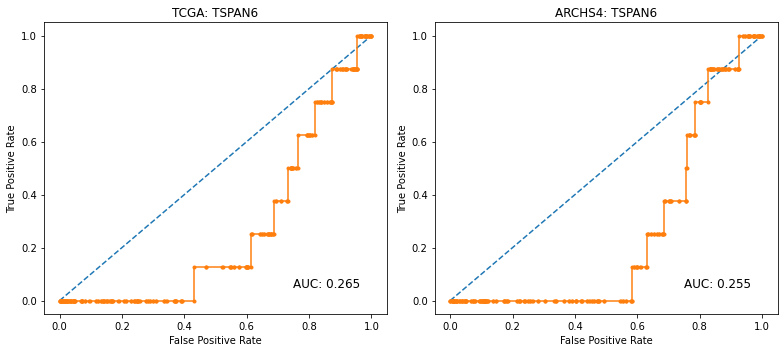

,Annotation,Score,Z-Score
1,tryptophan catabolic process (GO:0006569),28.753212,6.976074
2,indolalkylamine catabolic process (GO:0046218),1.952080,0.237865
3,succinyl-CoA metabolic process (GO:0006104),1.318757,0.078638
4,flavonoid glucuronidation (GO:0052696),1.134239,0.032247
5,glucuronate metabolic process (GO:0019585),0.882574,-0.031025
6,xenobiotic glucuronidation (GO:0052697),0.879446,-0.031812
7,ketone body metabolic process (GO:1902224),0.868269,-0.034622
8,cellular glucuronidation (GO:0052695),0.838705,-0.042055
9,coumarin metabolic process (GO:0009804),0.633114,-0.093743
10,ketone body biosynthetic process (GO:0046951),0.616864,-0.097829


In [20]:
process(libraries[1], tcga_genes, filtered_genes, tcga_cor, archs4_genes, np.array(archs4_cor))

# Predicted upstream transcription factors (ChEA)

In [21]:
process(libraries[4], tcga_genes, filtered_genes, tcga_cor, archs4_genes, np.array(archs4_cor))

Not enough gene annotations available.


,Annotation,Score,Z-Score
1,CASK,0.296471,6.334366
2,EPHA4,0.090763,1.365042
3,PINK1,0.087272,1.280719
4,EPHB2,0.074711,0.977277
5,KDR,0.056978,0.548892
6,TESK2,0.052449,0.439479
7,PDK4,0.044909,0.257351
8,PDK3,0.044909,0.257351
9,CAMKK2,0.044183,0.239799
10,MST4,0.041746,0.180935


# Predicted mouse phenotypes (MGI)

In [22]:
process(libraries[2], tcga_genes, filtered_genes, tcga_cor, archs4_genes, np.array(archs4_cor))

Not enough gene annotations available.


,Annotation,Score,Z-Score
1,MP:0004292 abnormal spiral ligament fibrocyte morphology,0.071681,3.084333
2,MP:0010570 prolonged ST segment,0.071452,3.021360
3,MP:0011442 abnormal renal sodium ion transport,0.069526,2.493247
4,MP:0004525 thin cochlear hair cell stereocilia,0.068536,2.221604
5,MP:0006083 abnormal blood vessel elastic tissue morphology,0.066758,1.733909
6,MP:0005199 abnormal iris pigment epithelium,0.064849,1.210540
7,MP:0000098 abnormal vomer bone morphology,0.064442,1.098880
8,MP:0000044 absent organ of Corti,0.064083,1.000280
9,MP:0003146 absent cochlear ganglion,0.063908,0.952209
10,MP:0004287 abnormal spiral limbus morphology,0.062142,0.467898


# Predicted pathways (KEGG)

In [24]:
process(libraries[0], tcga_genes, filtered_genes, tcga_cor, archs4_genes, np.array(archs4_cor))

Not enough gene annotations available.


,Annotation,Score,Z-Score
1,Drug metabolism,1.572296,3.776225
2,Cholesterol metabolism,1.459679,3.436534
3,Homologous recombination,1.148106,2.496721
4,Peroxisome,0.985529,2.006330
5,Bile secretion,0.951813,1.904632
6,Glutathione metabolism,0.738751,1.261960
7,Nucleotide excision repair,0.543093,0.671785
8,Collecting duct acid secretion,0.405921,0.258028
9,Glycosaminoglycan biosynthesis,0.377671,0.172815
10,Ferroptosis,0.352489,0.096859


# Predicted kinase interactions (KEA)

In [ ]:
process(libraries[-1], tcga_genes, filtered_genes, tcga_cor, archs4_genes, np.array(archs4_cor))

# Predicted human phenotypes

In [23]:
process(libraries[-1], tcga_genes, filtered_genes, tcga_cor, archs4_genes, np.array(archs4_cor))

KeyboardInterrupt: 